In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups
    sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                         dropout.present=(dropout != 0), method=method,
                         seed=42, dropout.shape=-1, dropout.mid=dropout)

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.api as sc
import DCA.api as dca

Using TensorFlow backend.


In [5]:
%%R
class(cellinfo$Cell)

[1] "factor"


In [6]:
#type(cellinfo)

type(cellinfo.Cell)
counts.shape
cellinfo.Cell.shape

(2000,)

In [11]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
adata

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [12]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true

AnnData object with n_obs × n_vars = 2000 × 200 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [37]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

type(adata_ae)

anndata.base.AnnData

In [20]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

res = dca.autoencode(adata_ae, training_kwargs={'verbose': False})


### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...


IndexError: Key "X_dca" is not valid observation/variable name/index.

In [23]:
type(res)
res

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts', 'DCA_split', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    uns: 'DCA_losses'
    obsm: 'X_dca', 'X_dca_mean', 'X_dca_hidden', 'X_dca_dropout', 'X_dca_dispersion'

In [36]:
adata_ae.X = res.obsm['X_dca']
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

adata_ae



from sklearn.manifold import TSNE
tsne = TSNE(verbose=1)
YY = tsne.fit_transform(res.obsm['X_dca_hidden'])

NameError: name 'tsne' is not defined

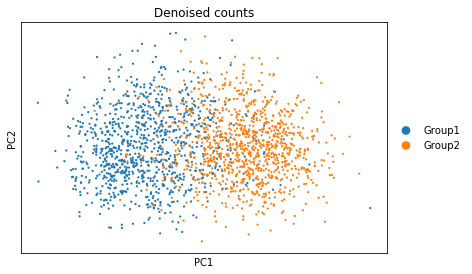

In [35]:
#sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
#sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')